In [1]:
import numpy as np
import re

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,SpatialDropout1D,LSTM
from keras.callbacks import EarlyStopping

import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import pandas as pd
pd.set_option('max_columns', None)

from data_frame import eda_nltk, remove_tags

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)


import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataframe = input(': ') #reviews_Automotive_5.json.gz
df = eda_nltk(dataframe)
df.head()

: reviews_Automotive_5.json.gz


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


In [3]:
df['positive'] = df.overall.apply(lambda x: 1 if x >= 4 else 0)
print(df.shape)


(20473, 10)


# Data Preprocessing

In [4]:
review_df = df[['reviewText','positive']]
review_df['reviewText']=review_df['reviewText'].apply(lambda cw : remove_tags(cw))



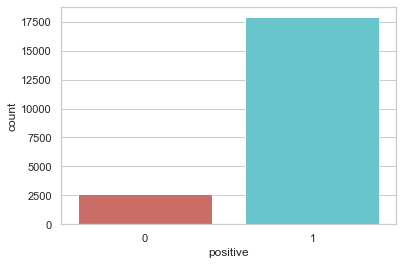

In [5]:
sns.countplot(x='positive',data = review_df, palette = 'hls')
plt.show()

# imbalanced data

## start random select

In [6]:
max_cnt = review_df.query('positive == 0').shape[0]
print(f'We should select only {max_cnt} count for both positive/ negative review')
sample_df = review_df.groupby(['positive']).apply(lambda x: x.sample(max_cnt))
sample_df.shape[0]

We should select only 2578 count for both positive/ negative review


5156

### remove stopwords from the review. Stopwords are commonly used words like ‘and’, ‘the’, ‘at’ that do not add any special meaning or significance to a sentence

In [7]:
sample_df['reviewText'] = sample_df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
sample_df['reviewText']

positive       
0         4608     first good seems well made pumps easily moves ...
          784      followed directions cleaning top much far clea...
          12746    screens really fit rv trim make fit plus use e...
          4586     expecting better charger could recommend one p...
          12153    headlights bad stuff much improve optional san...
                                         ...                        
1         4667     orange forgetful need full blown checklist cha...
          11035    trim everything company consistantly makes goo...
          11626    someone used many car cleaning products hunted...
          9548     bought two use recently obtained personalized ...
          2435     handy go dump connect sewer hose dump hold end...
Name: reviewText, Length: 5156, dtype: object

In [8]:

review_list = [i for i in sample_df['reviewText']]
review_list[:2]

['first good seems well made pumps easily moves decent amount fluid pump bad says fits quart containers would screw redline quart bottles also gallon jug pump fit either pick tube dropped jug naturally tube odd size nothing could find laying around garage would fit ended cutting top jug retrieve tube could finish job end result quite mess gear oil garage floor buy product make sure bottom tube pushed place tightly',
 'followed directions cleaning top much far cleaning grease top mechanism lower sides tan fabric top however provide nice protective water resistant coating applied others done instead using sprayer used brush coated top painting way goes heavier cause spray painted glass surfaces gave 3 star sure good rag top brand lot less expensive also noted top old properly cared bought car well may work lot better newer top']

In [21]:
sample_df['reviewText'].values

array(['first good seems well made pumps easily moves decent amount fluid pump bad says fits quart containers would screw redline quart bottles also gallon jug pump fit either pick tube dropped jug naturally tube odd size nothing could find laying around garage would fit ended cutting top jug retrieve tube could finish job end result quite mess gear oil garage floor buy product make sure bottom tube pushed place tightly',
       'followed directions cleaning top much far cleaning grease top mechanism lower sides tan fabric top however provide nice protective water resistant coating applied others done instead using sprayer used brush coated top painting way goes heavier cause spray painted glass surfaces gave 3 star sure good rag top brand lot less expensive also noted top old properly cared bought car well may work lot better newer top',
       'screens really fit rv trim make fit plus use extra tie wraps',
       ...,
       'someone used many car cleaning products hunted distributor

In [22]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(sample_df['reviewText'].values)
X = tokenizer.texts_to_sequences(sample_df['reviewText'].values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ...,  267,  549,  163],
       [   0,    0,    0, ...,   15,  969,  136],
       [   0,    0,    0, ...,    3,  314, 1348],
       ...,
       [   0,    0,    0, ...,    3,   95,  220],
       [   0,    0,    0, ...,    8,  286,  280],
       [   0,    0,    0, ...,   10,  767,    3]], dtype=int32)

In [9]:
# t=Tokenizer()
# t.fit_on_texts(review_list)
# sequences =t.texts_to_sequences(review_list)
# X = pad_sequences(sequences)
# print(X)

[[   0    0    0 ... 2188  163 2037]
 [   0    0    0 ...   15  969  136]
 [   0    0    0 ...  314 1348 3486]
 ...
 [   0    0    0 ... 4989   95  220]
 [   0    0    0 ...    8  286  280]
 [   0    0    0 ...    3 5533 8702]]


In [10]:
# print('sequences : ',sequences[:2],'\n')


# N = len([item for sublist in sequences[:2] for item in sublist])

# print('word_index : ',{k: t.word_index[k] for k in list(t.word_index)[:N]})


sequences :  [[33, 7, 98, 8, 39, 1610, 132, 2901, 593, 409, 393, 365, 154, 436, 242, 1950, 2280, 5, 531, 1870, 1950, 839, 17, 731, 2187, 365, 29, 255, 953, 549, 1575, 2187, 3485, 549, 1653, 135, 178, 44, 110, 3071, 77, 277, 5, 29, 594, 732, 136, 2187, 4054, 549, 44, 224, 59, 96, 760, 223, 872, 1065, 41, 277, 662, 38, 4, 30, 48, 267, 549, 2188, 163, 2037], [910, 577, 130, 136, 14, 127, 130, 442, 136, 1139, 601, 881, 5865, 1371, 136, 84, 761, 46, 2106, 26, 2189, 1066, 340, 289, 208, 293, 21, 1313, 10, 257, 1814, 136, 1951, 42, 329, 1496, 626, 123, 1254, 307, 653, 484, 40, 341, 48, 7, 1459, 136, 225, 79, 111, 247, 17, 1704, 136, 74, 437, 5866, 32, 2, 8, 97, 12, 79, 15, 969, 136]] 

word_index :  {'one': 1, 'car': 2, 'use': 3, 'product': 4, 'would': 5, 'like': 6, 'good': 7, 'well': 8, 'get': 9, 'used': 10, 'great': 11, 'work': 12, 'time': 13, 'much': 14, 'better': 15, 'really': 16, 'also': 17, 'works': 18, 'light': 19, 'battery': 20, 'using': 21, '2': 22, 'easy': 23, 'even': 24, 'little': 

In [11]:
# len_mat=[]
# for i in range(len(sequences)):
#     len_mat.append(len(sequences[i]))

In [12]:
# len(len_mat)

5156

In [23]:
s = 0.0
for i in sample_df['reviewText']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/sample_df.shape[0])
pos = 0
for i in range(sample_df.shape[0]):
    if sample_df.iloc[i]['positive'] == 1:
        pos = pos + 1
neg = sample_df.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/sample_df.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/sample_df.shape[0]*100)+"%")


Average length of each review :  48.649728471683474
Percentage of reviews with positive sentiment is 50.0%
Percentage of reviews with negative sentiment is 50.0%


# Build LSTM Model

In [39]:
max_features = 2000
embed_dim = 64
lstm_out = 16

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid',trainable=True))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 894, 64)           128000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 894, 64)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 16)                5184      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 133,201
Trainable params: 133,201
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
y = sample_df['positive']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)



(4124, 894) (4124,)
(1032, 894) (1032,)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, 
          epochs = 6,
          batch_size = batch_size,
          validation_data = (X_test, Y_test),
          callbacks = [EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=2,verbose=2)])

Epoch 1/6
129/129 [==============================] - 63s 475ms/step - loss: 0.6635 - accuracy: 0.6062 - val_loss: 0.5902 - val_accuracy: 0.6967
Epoch 2/6
129/129 [==============================] - 60s 465ms/step - loss: 0.4952 - accuracy: 0.7653 - val_loss: 0.5576 - val_accuracy: 0.7083
Epoch 3/6
129/129 [==============================] - 58s 447ms/step - loss: 0.4065 - accuracy: 0.8167 - val_loss: 0.5761 - val_accuracy: 0.7238
Epoch 4/6
129/129 [==============================] - 57s 444ms/step - loss: 0.3494 - accuracy: 0.8511 - val_loss: 0.6230 - val_accuracy: 0.7132
Epoch 5/6
 41/129 [========>.....................] - ETA: 37s - loss: 0.3045 - accuracy: 0.8834